# Una aplicación del algoritmo de Grover

Utilizo el algoritmo de Grover para buscar dos elementos en una pequeña base de datos. 

In [1]:
#importamos todo lo necesario (y mucho más)
import qiskit
from qiskit import *
from qiskit.visualization import plot_histogram, plot_bloch_multivector
import math
from math import pi
import matplotlib
%matplotlib inline

Supongamos que nuestros colegas de el Instituto de Investigaciones en Materiales tienen la siguiente base de datos. Esta base de datos presenta distintos materiales numerados del 0-7 (en binario) de los cuales se conocen sus estructuras cristalinas. Estas estructuras resultaron ser solamente una de cuatro: Cúbica simple (SC), cúbica centrada en las caras (FCC), cúbica centrada en el cuerpo (BCC), y hexagonal (HCP). La base de datos es la siguiente:



    
| No. Material | SC | FCC | BCC| HCP |
| --- | --- | --- | --- | --- |
| 000 | 0 | 1 | 0 | 0 |
| 001 | 0 | 0 | 1 | 0 |
| 010 | 0 | 1 | 0 | 0 |
| 011 | 1 | 0 | 0 | 0 |
| 100 | 0 | 0 | 1 | 0 |
| 101 | 1 | 0 | 0 | 0 |
| 110 | 0 | 0 | 0 | 1 |
| 111 | 0 | 0 | 0 | 1 |



Ellos quieren un algoritmo que les ayude a buscar en su base de datos los materiales que cristalizan en alguna estructura en especial. Nos ofrecemos a ayudarles implementando el algoritmo de Grover, pues suponemos que esta situación ocurre en un futuro (esperemos no muy lejano) en el que podemos utilizar computo cuántico en nuestro día a día.


Implementaré una compuerta $U_X$ que marque a los materiales con la estructura $X=CS,FCC,BCC,HCP$ invirtiendo su signo. La implementación de estas compuertas se puede ver como lo siguiente:

  - Dados el estado de superposición entre los dos estados cuyo signo hay que invertir, aplicamos las compuertas $X$ necesarias para llevar el primero de ellos al estado $|111\rangle$. $$|A\rangle+|B\rangle \rightarrow |111\rangle+|B'\rangle $$
  - Aplicamos una compuerta CCZ según el resultado visto en la tarea 3-2. Dicha compuerta cambiará de signo el primero de los estados.
  $$|A'\rangle+|B'\rangle \rightarrow -|111\rangle+|B'\rangle  $$
  - Aplicamos las compuertas $X$ necesarias para llevar el estado $|B'\rangle$ a $|111\rangle$
  $$-|111\rangle+|B'\rangle \rightarrow -|A'\rangle+|111\rangle  $$
  - Nuevamente aplicamos la compuerta CCZ
   $$-|A'\rangle+|111\rangle \rightarrow -|A'\rangle-|111\rangle $$
  - Aplicamos las dos series de compuertas $X$ anteriormente aplicadas para llegar al estado original
  $$-|A'\rangle-|111\rangle \rightarrow -|A\rangle-|B\rangle$$
  
Posteriormente utilizaré el algoritmo de Grover, considerando una sola iteración, utilizando un resultado mostrado en el paper de Boyer-Brassard, mostrado en la bibliografía como [3].

## Preparativos: La compuertas $U_s$ y $CCZ$
La primera de estas será necesaria para completar una iteración del algoritmo de Grover, después de aplicar el oráculo a los estados correspondientes.
La segunda de ellas será útil para implementar los oráculos $U_X$-

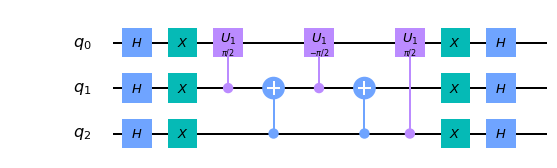

In [2]:
# Implementación de las compuertas U_s, CCZ, vistas en clase y en la Tarea 3-2
n=3
def us(circuit):
    for i in range(0,n):
        circuit.h(i)
    for i in range(0,n):
        circuit.x(i)
    circuit.cu1(pi/2,1,0)
    circuit.cx(2,1)
    circuit.cu1(-pi/2,1,0)
    circuit.cx(2,1)
    circuit.cu1(pi/2,2,0)
    for i in range(0,n):
        circuit.x(i)
    for i in range(0,n):
        circuit.h(i)  
        
Us=QuantumCircuit(3)
us(Us)
Us.draw(output="mpl")

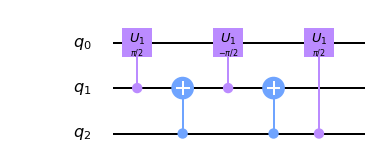

In [3]:
def ccz(circuit):
    circuit.cu1(pi/2,1,0)
    circuit.cx(2,1)
    circuit.cu1(-pi/2,1,0)
    circuit.cx(2,1)
    circuit.cu1(pi/2,2,0)
    
CCZ=QuantumCircuit(3)
ccz(CCZ)
CCZ.draw(output="mpl") 

## Buscando materiales CS 
La compuerta implementada $U_{CS}$ invierte el signo de los estados $|011\rangle$ y $|101\rangle$, lo cual permite encontrarlos al aplicar el algoritmo de Grover.

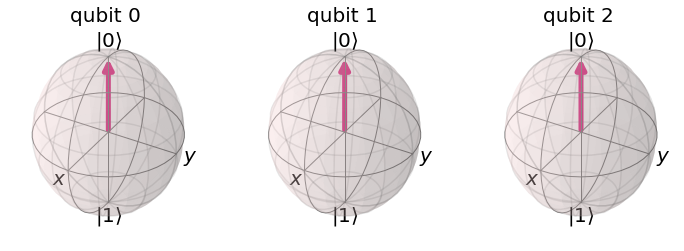

In [4]:
#Implementación de una secuencia de compuertas que invierte el signo a los estados deseados
# La compuerta U_CS se encuentra entre las barreras.
def u_CS(circuit):
    circuit.barrier()
    circuit.x(2)
    ccz(circuit)
    circuit.x({1,2})
    ccz(circuit)
    circuit.x(2)
    circuit.x({1,2})
    circuit.barrier()

# Se muestra el estado inicial en la esfera de Bloch
qcCS=QuantumCircuit(3,3)
backend = Aer.get_backend('statevector_simulator')
out = execute(qcCS,backend).result().get_statevector()
plot_bloch_multivector(out)


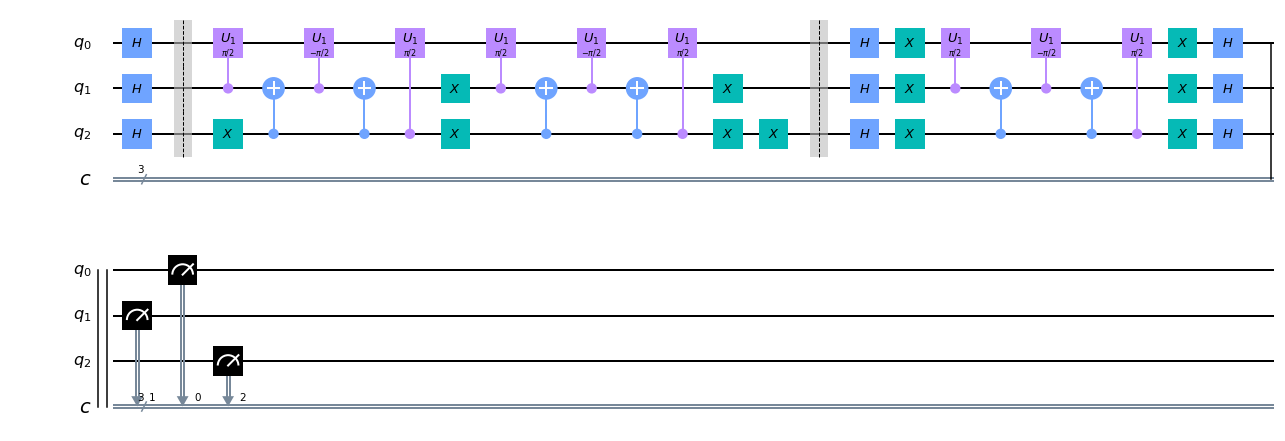

In [5]:
# Algoritmo de Grover con una iteración.
qcCS.h(range(0,3))
u_CS(qcCS)
us(qcCS)
qcCS.measure(range(0,3),range(0,3))
qcCS.draw(output='mpl')


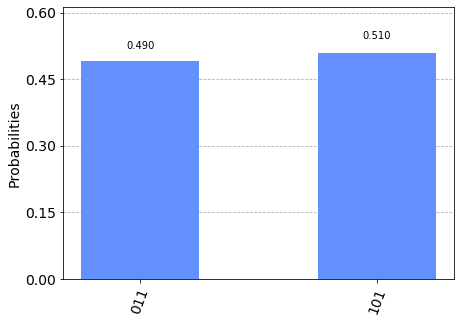

In [7]:
# Resultados estado final del algoritmo en histograma
qasm = Aer.get_backend('qasm_simulator')
job = execute(qcCS, qasm, shots=1000)
result = job.result()
countsCS = result.get_counts(qcCS) 
plot_histogram(countsCS)

Vemos que si $A=\{|011\rangle,|101\rangle\}$ el estado final es aproximadamente $$|\Psi_1\rangle\approx\frac{1}{\sqrt{2}}(|011\rangle+|101\rangle)+0\sum_{x\notin A}|x\rangle=\frac{1}{\sqrt{2}}(|011\rangle+|101\rangle)$$

Por lo que decimos que los qubits deseados han sido encontrados.

## Buscando materiales FCC
La compuerta implementada $U_{FCC}$ invierte el signo de los estados $|000\rangle$ y $|010\rangle$, lo cual permite encontrarlos al aplicar el algoritmo de Grover.

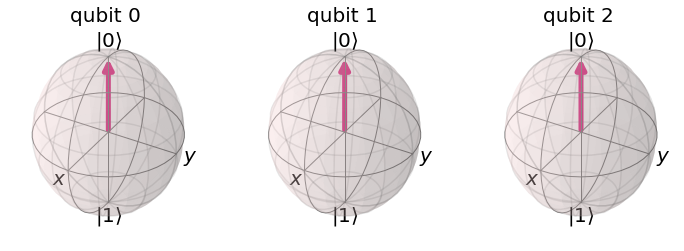

In [8]:
#Implementación de una secuencia de compuertas que invierte el signo a los estados deseados
# La compuerta U_FCC se encuentra entre las barreras.
def u_FCC(circuit):
    circuit.barrier()
    circuit.x(0)
    circuit.x(1)
    circuit.x(2)
    ccz(circuit)
    circuit.x(1)
    ccz(circuit)
    circuit.x(1)
    circuit.x(0)
    circuit.x(1)
    circuit.x(2)
    circuit.barrier()
    
# Se muestra el estado inicial en la esfera de Bloch
qcFCC=QuantumCircuit(3,3)
out = execute(qcFCC,backend).result().get_statevector()
plot_bloch_multivector(out)

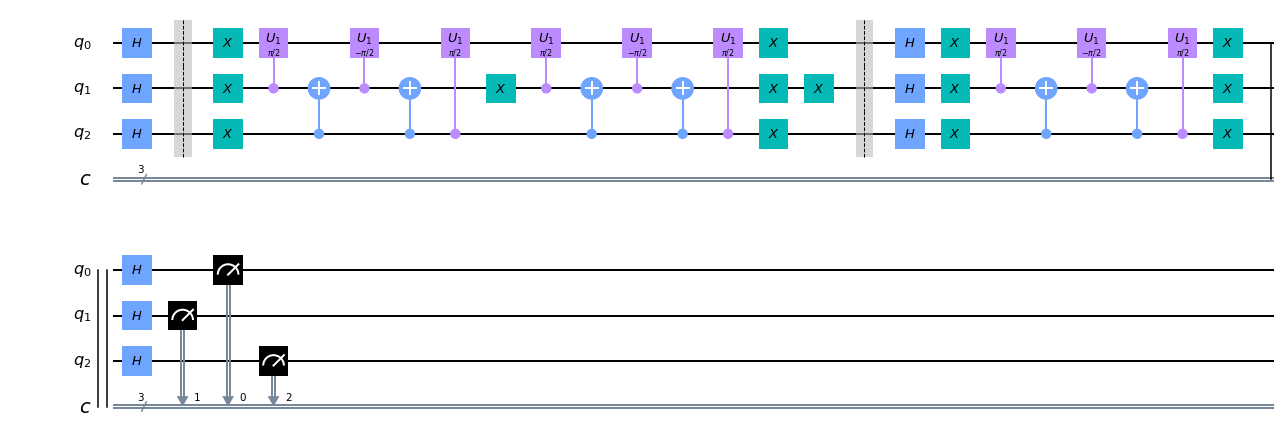

In [9]:
# Algoritmo de Grover con una iteración
qcFCC.h(range(0,3))
u_FCC(qcFCC)
us(qcFCC)
qcFCC.measure(range(0,3),range(0,3))
qcFCC.draw(output='mpl')

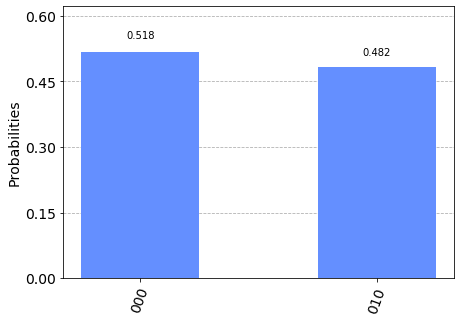

In [10]:
# Resultados finales del algoritmo en histograma
job = execute(qcFCC, qasm, shots=1000)
result = job.result()
counts = result.get_counts(qcFCC) 
plot_histogram(counts)

Vemos que si ahora $A'=\{|000\rangle,|010\rangle\}$ el estado final es aproximadamente $$|\Psi_1\rangle\approx\frac{1}{\sqrt{2}}(|000\rangle+|010\rangle)+0\sum_{x\notin A'}|x\rangle=\frac{1}{\sqrt{2}}(|000\rangle+|010\rangle)$$

Nuevamente los qubits deseados han sido encontrados.

## Buscando materiales BCC
La compuerta implementada $U_{BCC}$ invierte el signo de los estados $|001\rangle$ y $|100\rangle$, lo cual permite encontrarlos al aplicar el algoritmo de Grover.

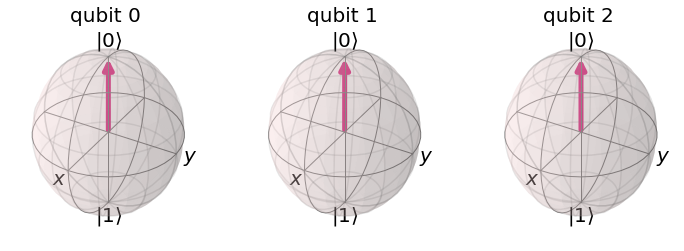

In [11]:
#Implementación de una secuencia de compuertas que invierte el signo a los estados deseados
# La compuerta U_BCC se encuentra entre las barreras.
def u_BCC(circuit):
    circuit.barrier()
    circuit.x({1,2})
    ccz(circuit)
    circuit.x({0,2})
    ccz(circuit)
    circuit.x({1,2})
    circuit.x({0,2})
    circuit.barrier()

# Se muestra el estado inicial en la esfera de Bloch
qcBCC=QuantumCircuit(3,3)
out = execute(qcBCC,backend).result().get_statevector()
plot_bloch_multivector(out)

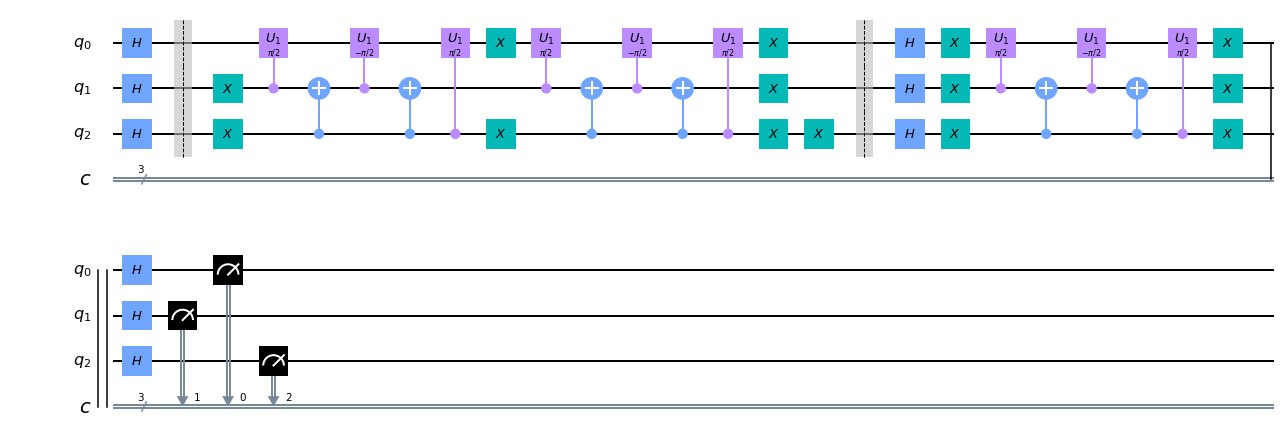

In [12]:
# Algoritmo de Grover con una iteración
qcBCC.h(range(0,3))
u_BCC(qcBCC)
us(qcBCC)
qcBCC.measure(range(0,3),range(0,3))
qcBCC.draw(output='mpl')

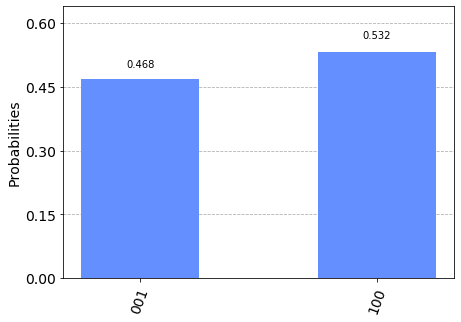

In [13]:
# Resultados finales del circuito en histograma
job = execute(qcBCC, qasm, shots=1000)
result = job.result()
countsBCC = result.get_counts(qcBCC) 
plot_histogram(countsBCC)


Vemos que si ahora $\tilde{A}=\{|001\rangle,|100\rangle\}$ el estado final es aproximadamente $$|\Psi_1\rangle\approx\frac{1}{\sqrt{2}}(|001\rangle+|100\rangle)+0\sum_{x\notin \tilde{A}}|x\rangle=\frac{1}{\sqrt{2}}(|001\rangle+|100\rangle)$$

Una vez más, los qubits deseados han sido encontrados.

## Buscando materiales HCP
La compuerta implementada $U_{HCP}$ invierte el signo de los estados $|110\rangle$ y $|111\rangle$, lo cual permite encontrarlos al aplicar el algoritmo de Grover.

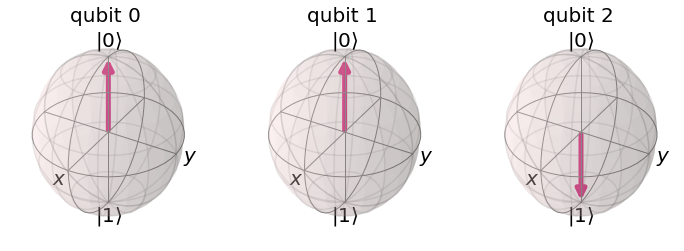

In [14]:
#Implementación de una secuencia de compuertas que invierte el signo a los estados deseados
# La compuerta U_HCP se encuentra entre las barreras.
def u_HCP(circuit):
    circuit.barrier()
    circuit.x(0)
    ccz(circuit)
    circuit.x(0)
    ccz(circuit)
    circuit.barrier()
    
# Se muestra el estado inicial en la esfera de Bloch  
qcH=QuantumCircuit(4,3)
out = execute(qcBCC,backend).result().get_statevector()
plot_bloch_multivector(out)

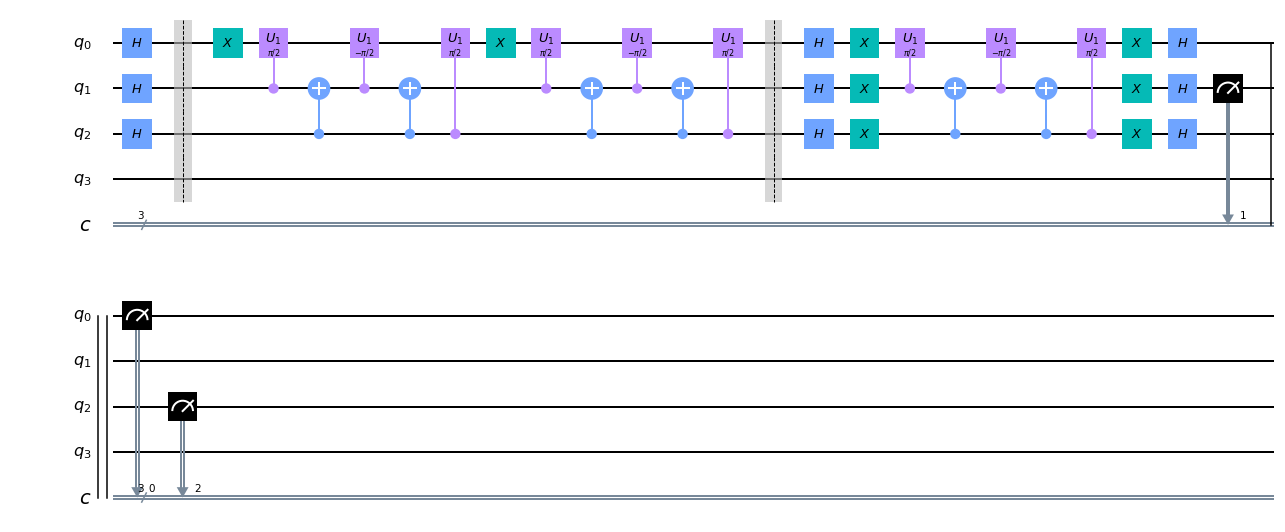

In [15]:
# Algoritmo de Grover con una iteración
qcH.h(range(0,3))
u_HCP(qcH)
us(qcH)
qcH.measure(range(0,3),range(0,3))
qcH.draw(output='mpl')

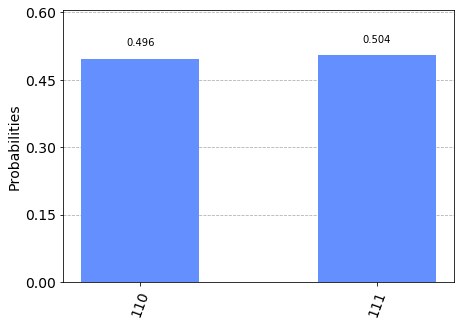

In [16]:
# Resultados finales del algoritmo en histograma 
job = execute(qcH, qasm, shots=1000)
result = job.result()
countsHCP = result.get_counts(qcH) 
plot_histogram(countsHCP)

Vemos que si ahora $\hat{A}=\{|110\rangle,|111\rangle\}$ el estado final es aproximadamente $$|\Psi_1\rangle\approx\frac{1}{\sqrt{2}}(|110\rangle+|111\rangle)+0\sum_{x\notin \hat{A}}|x\rangle=\frac{1}{\sqrt{2}}(|110\rangle+|111\rangle)$$

Hemos encontrado el último par de qubits.

## Implementación de una función "interpretadora de resultados"
Para cada estructura cristalina, definiremos una función de Python que toma como argumento alguna estructura cristalina, y regresa como resultado los números de los materiales que satisfacen tener dicha estructura. Esta función toma como argumento el tipo de estructura _**entre comillas**_.

In [17]:
def find(struct):
    if struct=="CS":
        #Utilizamos la siguiente forma de ordenar el diccionario countsCS, hacemos lista anidada
        countsCS_L=sorted(countsCS.items(), key=lambda x: x[1])
        #Accedemos a los estados que se obtuvieron en counts, serán los estados buscados
        print("Los materiales que criztalizan en CS son:", countsCS_L[0][0], ",", countsCS_L[1][0])
    elif struct== "FCC":
        countsFCC_L=sorted(countsFCC.items(), key=lambda x: x[1])
        print("Los materiales que criztalizan en FCC son:", countsFCC_L[0][0], ",", countsFCC_L[1][0])
    elif struct== "BCC":
        countsBCC_L=sorted(countsBCC.items(), key=lambda x: x[1])
        print("Los materiales que criztalizan en BCC son:", countsBCC_L[0][0],",", countsBCC_L[1][0])
    elif struct=="HCP":
        countsHCP_L=sorted(countsHCP.items(), key=lambda x: x[1])
        print("Los materiales que criztalizan en HCP son:", countsHCP_L[0][0],",",countsHCP_L[1][0])

Ahora solo resta llamar la función <code>find()<code>

In [32]:
# El usuario puede cambiar el tipo de estructura entre comillas para verificar con la Tabla 1
find("HCP")

Los materiales que criztalizan en HCP son: 110 , 111


## Comentarios finales
Nuestros colegas del IIM ya tienen un algoritmo de búsqueda funcional. Si bien la parte de la "función interpretadora" puede reducir la ventaja de todo el algoritmo, el elemento de búsqueda en si, que es el algoritmo de Grover, presenta  una gran ventaja. Este corre en una sola iteración, cuando clásicamente habría que hacer ocho.

### Bibliografía:
- [1] Grover, L. K. (1996, Julio). _A fast quantum mechanical algorithm for database search._ In Proceedings of the twenty-eighth annual ACM symposium on Theory of computing (pp. 212-219).
- [2] Nielsen, M. A., & Chuang, I. (2002). _Quantum computation and quantum information._
- [3] Boyer, M., Brassard, G., Høyer, P., & Tapp, A. (1998). _Tight bounds on quantum searching._ Fortschritte der Physik: Progress of Physics, 46(4‐5), 493-505.
    